# Sensorless Drive Diagnosis

> In this example, the main focus is the classification of individual states of a motor.

In [ ]:
# |hide
from nbdev.showdoc import *

In [ ]:
# | hide
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import copy

# from mlflow import log_metric, log_param, log_artifacts
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from matplotlib import pyplot as plt
import seaborn as sns

from mlmvn.layers import FirstLayer, HiddenLayer, OutputLayer, cmplx_phase_activation
from mlmvn.loss import ComplexMSELoss
from mlmvn.optim import MySGD, ECL

import wandb

In [ ]:
wandb.login()

wandb: Currently logged in as: antonpf. Use `wandb login --relogin` to force relogin


True

In [ ]:
# | hide
# --- helper functions ---
def reverse_one_hot(x, neuronCats):
    a = np.zeros(len(x))
    x = torch.detach(x)
    for i in range(len(x)):
        a[i] = torch.max(x[i]) - 1 + np.argmax(x[i]) * neuronCats
    return a


def accuracy(out, yb):
    out = out.type(torch.double)
    yb = yb.type(torch.double)
    x = 0
    for i in range(len(out)):
        x += torch.equal(out[i], yb[i])
    return x / len(out)


def prepare_data(x_train, x_valid, y_train, y_valid, neuronCats):
    # one-hot encoding
    numSamples, numFeatures = x_valid.shape
    y_valid_int = y_valid
    y2 = y_valid + 1  # auxiliary variable so that classes start at 1 and not 0
    numClasses = max(y2)
    target_ids = range(numClasses)
    no = int(np.ceil(numClasses / neuronCats))  # number of output neurons
    if no != 1:
        y_valid = torch.zeros(numSamples, no)
        for i in range(numSamples):
            k = int(np.ceil(y2[i] / neuronCats)) - 1
            c = np.mod((y2[i] - 1), neuronCats) + 1
            y_valid[i, k] = c
    numSamples, numFeatures = x_train.shape
    y_train_int = y_train
    y2 = y_train + 1  # auxiliary variable so that classes start at 1 and not 0
    if no != 1:
        y_train = torch.zeros(numSamples, no)
        for i in range(numSamples):
            k = int(np.ceil(y2[i] / neuronCats)) - 1
            c = np.mod((y2[i] - 1), neuronCats) + 1
            y_train[i, k] = c
    del y2

    # Convert numpy arrays into torch tensors
    x_train, y_train, x_valid, y_valid = map(
        torch.tensor, (x_train, y_train, x_valid, y_valid)
    )
    if y_train.size().__len__() == 1:
        y_train = torch.unsqueeze(y_train, 1)
        y_valid = torch.unsqueeze(y_valid, 1)

    # convert angles to complex numbers on unit-circle
    x_train = torch.exp(1.0j * x_train)
    x_valid = torch.exp(1.0j * x_valid)

    return x_train, x_valid, y_train, y_valid


def get_splitted_data(X, y, neuronCats):
    x_train, x_valid, y_train, y_valid = train_test_split(
        X, y, train_size=46806, random_state=42
    )
    x_train, x_valid, y_train, y_valid = prepare_data(
        x_train, x_valid, y_train, y_valid, neuronCats
    )

    return x_train, x_valid, y_train, y_valid


def get_splitted_data_by_index(X, y, neuronCats, train_index, test_index):
    x_train, x_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    x_train, x_valid, y_train, y_valid = prepare_data(
        x_train, x_valid, y_train, y_valid, neuronCats
    )
    return x_train, x_valid, y_train, y_valid


# --- Plots ---
def plot_loss(title, losses, scores):
    plt.rcParams["axes.grid"] = True
    fig, (ax1) = plt.subplots(1, 1, figsize=(8, 4))
    fig.suptitle("CVNN - Moons")
    ax1.plot(np.linspace(1, len(losses), len(losses)), losses)
    ax1.set_xlabel("Epoch")
    ax1.set_xlim(0, len(losses))

    ax1.plot(np.linspace(1, len(scores), len(scores)), scores)
    ax1.set_xlabel("Epoch")
    ax1.set_xlim(0, len(losses))

    ax1.legend(["Acc", "Loss"])

    plt.show()


def plot_weights(title, ylabel_1, ylabel_2, weights_real, weights_imag):
    # y_min = np.min([np.min(weights_real), np.min(weights_imag)])
    # y_max = np.max([np.max(weights_real), np.max(weights_imag)])

    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 3))
    fig.suptitle(title)
    ax[0].plot(np.linspace(1, len(weights_real), len(weights_real)), weights_real)
    ax[0].set_xlabel("Step")
    ax[0].set_ylabel(ylabel_1)
    # ax[0].set_title("Real Valued Weigts")
    ax[0].set_xlim(0, len(weights_real))
    # ax[0].set_ylim(y_min, y_max)

    ax[1].plot(np.linspace(1, len(weights_imag), len(weights_imag)), weights_imag)
    ax[1].set_xlabel("Step")
    ax[1].set_ylabel(ylabel_2)
    # ax[1].set_title("Imaginary Valued Weights")
    ax[1].set_xlim(0, len(weights_imag))
    # ax[1].set_ylim(y_min, y_max)

    plt.show()


def plot_loss_acc_list(title, list_losses, list_scores, image_name):
    losses = np.mean(list_losses, axis=0)
    scores = np.mean(list_scores, axis=0)

    losses_std = np.std(list_losses, axis=0)
    scores_std = np.std(list_scores, axis=0)

    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 3))
    fig.suptitle(title)
    ax1.plot(np.linspace(1, len(losses), len(losses)), losses)
    ax1.fill_between(
        np.linspace(1, len(losses), len(losses)),
        losses + losses_std,
        losses - losses_std,
        alpha=0.5,
        linewidth=0,
    )

    ax1.plot(np.linspace(1, len(scores), len(scores)), scores)
    ax1.fill_between(
        np.linspace(1, len(scores), len(scores)),
        scores + scores_std,
        scores - scores_std,
        alpha=0.5,
        linewidth=0,
    )
    ax1.set_xlabel("Epoch")

    plt.legend(["Loss Mean", "Loss Std", "Acc. Mean", "Acc. Std"])
    fig.savefig(image_name, format="png", dpi=600)

    plt.show()
    # save
    # fig.savefig(image_name + ".svg", format="svg", dpi=600)


# --- Logging ---
model_dict: dict = {}


def fc_hook(layer_name, module, grad_input, grad_output):
    if layer_name in model_dict:
        model_dict[layer_name]["weights"].append(module.weights.detach().clone())
        model_dict[layer_name]["bias"].append(module.bias.detach().clone())
        model_dict[layer_name]["grad_input"].append(grad_input)
        model_dict[layer_name]["grad_output"].append(grad_output)
    else:
        model_dict[layer_name] = {}
        model_dict[layer_name]["weights"] = []
        model_dict[layer_name]["weights"].append(module.weights.detach().clone())
        model_dict[layer_name]["bias"] = []
        model_dict[layer_name]["bias"].append(module.bias.detach().clone())
        model_dict[layer_name]["grad_input"] = []
        model_dict[layer_name]["grad_input"].append(grad_input)
        model_dict[layer_name]["grad_output"] = []
        model_dict[layer_name]["grad_output"].append(grad_output)

In [ ]:
# | hide
# control variables
# number of categories a neuron can distinguish / parameter that determines the number of output neurons
neuronCats = 1
# number of categories per neuron, i.e. neuronCats (+ 1 for others in case of multiple Outputs)
categories = 2
# how often a classification sector occurs (1 means no periodicity)
periodicity = 1
# path to store best model parameters
PATH = "/run/media/antonp/Daten/Dev/mlmvn_pytorch/mlmvn/nbs/examples/autass/models/autass-mlmvn_48-100-11.pt"

## Load Data

In [ ]:
train_csv = pd.read_csv(
    "data/autass_data2.csv",
    header=None,
    dtype=np.double,
)
data = np.array(train_csv.values[:, 1:50])
del train_csv

In [ ]:
X = data[:, 0:48]
y = data[:, 48].astype(int) - 1

yt = copy.copy(y)
yt[yt == 0] = 20
yt[yt == 1] = 21
yt[yt == 2] = 22
yt[yt == 3] = 23
yt[yt == 4] = 26
yt[yt == 5] = 24
yt[yt == 6] = 27
yt[yt == 7] = 29
yt[yt == 8] = 30
yt[yt == 9] = 25
yt[yt == 10] = 28
yt -= 20
y = yt
del yt

## Model

In [ ]:
class Model(nn.Module):
    def __init__(self, categories, periodicity):
        super().__init__()
        self.categories = categories
        self.periodicity = periodicity
        self.first_linear = FirstLayer(48, 100)
        self.phase_act1 = cmplx_phase_activation()
        self.linear_out = OutputLayer(100, 11)
        self.phase_act2 = cmplx_phase_activation()
        # # Hooks
        # self.first_layer_hook_handle = self.first_linear.register_full_backward_hook(
        #     self.first_layer_backward_hook
        # )
        # self.output_hook_handle = self.linear_out.register_full_backward_hook(
        #     self.output_layer_backward_hook
        # )

    def forward(self, x):
        x = self.first_linear(x)
        x = self.phase_act1(x)
        x = self.linear_out(x)
        x = self.phase_act2(x)
        return x

    def first_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("first_layer", module, grad_input, grad_output)

    def hidden_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("hidden_layer", module, grad_input, grad_output)

    def output_layer_backward_hook(self, module, grad_input, grad_output):
        fc_hook("output_layer", module, grad_input, grad_output)

    def angle2class(self, x: torch.tensor) -> torch.tensor:
        tmp = x.angle() + 2 * np.pi
        angle = torch.remainder(tmp, 2 * np.pi)

        # This will be the discrete output (the number of sector)
        o = torch.floor(self.categories * self.periodicity * angle / (2 * np.pi))
        return torch.remainder(o, self.categories)

    def predict(self, x):
        """
        Performs the prediction task of the network

        Args:
          x: torch.Tensor
            Input tensor of size ([3])

        Returns:
          Most likely class i.e., Label with the highest score
        """
        # Pass the data through the networks
        output = self.forward(x)

        # # Choose the label with the highest score
        # return torch.argmax(output, 1)
        return self.angle2class(output)


def fit(model, X, y, epochs, batch_size, optimizer, criterion, categories, periodicity):
    # List of losses for visualization
    losses = []
    scores = []
    acc_best = 0

    # start a new experiment
    wandb.init(project="SDD-mlmvn", entity="antonpf")

    #  capture a dictionary of hyperparameters with config
    wandb.config = {
        "learning_rate": 1,
        "epochs": epochs,
        "batch_size": batch_size,
        "optim": "ECL",
        "categories": categories,
        "periodicity": periodicity,
        "layer": "[48-100-11]",
    }

    for i in range(epochs):
        # Pass the data through the network and compute the loss
        # We'll use the whole dataset during the training instead of using batches
        # in to order to keep the code simple for now.

        batch_loss = []

        for j in range((X.shape[0] - 1) // batch_size + 1):
            start_j = j * batch_size
            end_j = start_j + batch_size
            xb = X[start_j:end_j]
            yb = y[start_j:end_j]

            y_pred = model(xb)
            loss = criterion(y_pred, yb, categories, periodicity)
            batch_loss.append((torch.abs(loss)).detach().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step(inputs=xb, layers=list(model.children()))

        losses.append(sum(batch_loss) / len(batch_loss))
        if i % 10 == 9:
            print(f"Epoch {i} loss is {losses[-1]}")
        y_pred = model.predict(X)
        scores.append(accuracy(y_pred.squeeze(), y))

        log_dict = {
            "loss": torch.tensor(losses[-1]),
            "acc": torch.tensor(scores[-1]),
        }
        wandb.log(log_dict)

        # for key in model_dict:
        #     for key_layer in model_dict[key]:
        #         if key_layer in ["weights", "bias"]:
        #             log_label = str(key) + "_" + str(key_layer)
        #             log_label.replace(" ", "")
        #             wandb.log(
        #                 {
        #                     log_label
        #                     + "_real": wandb.Histogram(
        #                         model_dict[key][key_layer][-1].real
        #                     ),
        #                     log_label
        #                     + "_imag": wandb.Histogram(
        #                         model_dict[key][key_layer][-1].imag
        #                     ),
        #                     log_label
        #                     + "_mag": torch.abs(model_dict[key][key_layer][-1]),
        #                     log_label
        #                     + "_angle": torch.angle(model_dict[key][key_layer][-1]),
        #                 }
        #             )

        if scores[-1] > acc_best:
            acc_best = scores[-1]
            torch.save(model.state_dict(), PATH)

    return losses, scores

In [ ]:
model = Model(categories=categories, periodicity=periodicity)
epochs = 200
batch_size = 538
lr = 1
criterion = ComplexMSELoss.apply
optimizer = ECL(model.parameters(), lr=lr)

In [ ]:
x_train, x_valid, y_train, y_valid = get_splitted_data(X, y, neuronCats)

losses, scores = fit(
    model,
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    optimizer=optimizer,
    criterion=criterion,
    categories=categories,
    periodicity=periodicity,
)

model.load_state_dict(torch.load(PATH))

plot_loss(
    "CVNN - Autass",
    losses,
    scores,
)

y_pred = model.predict(x_train)
acc = accuracy(y_pred.squeeze(), y_train)
print("Train Acc.: ", acc)

y_pred = model.predict(x_valid)
acc = accuracy(y_pred.squeeze(), y_valid)
print("Val Acc.: ", acc)

print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))

Epoch 9 loss is 0.11467477424779243
Epoch 19 loss is 0.07103397985116855
Epoch 29 loss is 0.061110800927285824
Epoch 39 loss is 0.05612390729371852
Epoch 49 loss is 0.05755218794006612
Epoch 59 loss is 0.05011145414095284
Epoch 69 loss is 0.04560203592095569
Epoch 79 loss is 0.03906279908470004
Epoch 89 loss is 0.03606708531771284
Epoch 99 loss is 0.03728207701803584
Epoch 109 loss is 0.03377671005648842
Epoch 119 loss is 0.035183003270241445
Epoch 129 loss is 0.03136096161831314
Epoch 139 loss is 0.030035327149109663
Epoch 149 loss is 0.03067666302214878
Epoch 159 loss is 0.02747269773755479
Epoch 169 loss is 0.02956413597358904
Epoch 179 loss is 0.029255775382918372
Epoch 189 loss is 0.026400348127052234
Epoch 199 loss is 0.02391605622613005


<All keys matched successfully>

/tmp/ipykernel_210316/3139655883.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(


Epoch 9 loss is 0.09555149603237259
Epoch 19 loss is 0.07180477353342492
Epoch 29 loss is 0.05866701346681116
Epoch 39 loss is 0.05279493156188689
Epoch 49 loss is 0.0452284514882921
Epoch 59 loss is 0.04432152845561317
Epoch 69 loss is 0.04120528160817332
Epoch 79 loss is 0.03872579528805504
Epoch 89 loss is 0.04012878403705545
Epoch 99 loss is 0.03670449117350519
Epoch 109 loss is 0.03500836662407047
Epoch 119 loss is 0.038819575977518325
Epoch 129 loss is 0.03518220056085692
Epoch 139 loss is 0.0334206599348604
Epoch 149 loss is 0.04288051790237454
Epoch 159 loss is 0.02946339431988543
Epoch 169 loss is 0.028622828355258565
Epoch 179 loss is 0.026004774451050074
Epoch 189 loss is 0.04234084029874179
Epoch 199 loss is 0.030533800342442685


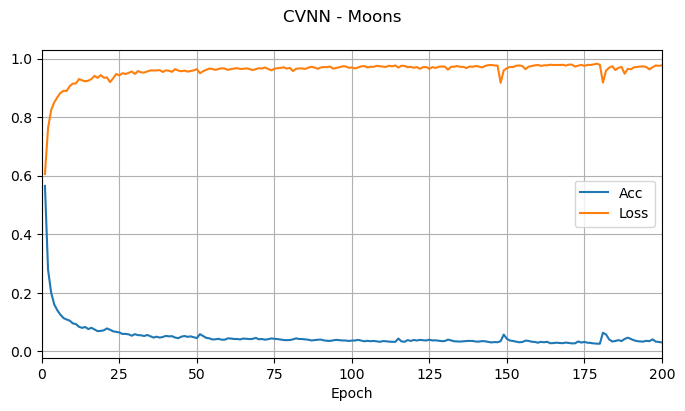

Train Acc.:  0.9826521674108574
Val Acc.:  0.9675269184754742
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1063
           1       0.96      0.97      0.97      1064
           2       1.00      0.99      1.00      1064
           3       0.99      0.98      0.99      1064
           4       0.98      0.94      0.96      1064
           5       0.98      0.96      0.97      1063
           6       0.96      0.97      0.96      1064
           7       1.00      1.00      1.00      1064
           8       1.00      1.00      1.00      1064
           9       0.98      0.96      0.97      1064
          10       0.98      0.98      0.98      1064

   micro avg       0.98      0.98      0.98     11702
   macro avg       0.98      0.98      0.98     11702
weighted avg       0.98      0.98      0.98     11702
 samples avg       0.97      0.98      0.97     11702



/tmp/ipykernel_210316/3139655883.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(


acc,▁▅▆▆▆▇▇▇▇▇▇▇█▇███████████████▆███████▇██
loss,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
acc,0.97684
loss,0.03053


Epoch 9 loss is 0.03280515257786979
Epoch 19 loss is 0.026678701807285887
Epoch 29 loss is 0.03428249728793015
Epoch 39 loss is 0.02977930542467795
Epoch 49 loss is 0.025499933276872333
Epoch 59 loss is 0.026383428557948122
Epoch 69 loss is 0.04087566840573189
Epoch 79 loss is 0.03320929960297722
Epoch 89 loss is 0.028597431276055053
Epoch 99 loss is 0.029255667306228448
Epoch 109 loss is 0.02957132606540668
Epoch 119 loss is 0.02789161873250058
Epoch 129 loss is 0.024786731106916184
Epoch 139 loss is 0.02688280216080345
Epoch 149 loss is 0.02539790177521539
Epoch 159 loss is 0.028236120375813925
Epoch 169 loss is 0.026298448108352458
Epoch 179 loss is 0.024100379332215163
Epoch 189 loss is 0.025749880920152932
Epoch 199 loss is 0.023991904507167372


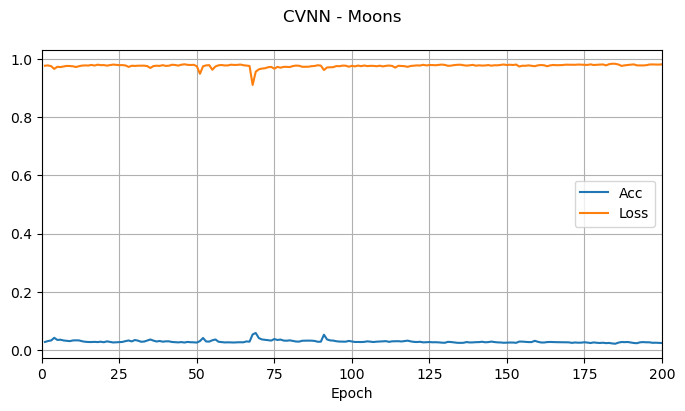

Train Acc.:  0.9841690345461149
Val Acc.:  0.9720560587933686
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1063
           1       0.97      0.96      0.96      1064
           2       1.00      0.99      0.99      1064
           3       0.99      0.99      0.99      1063
           4       0.97      0.97      0.97      1064
           5       0.98      0.97      0.97      1064
           6       0.97      0.97      0.97      1064
           7       1.00      1.00      1.00      1064
           8       1.00      1.00      1.00      1064
           9       0.98      0.96      0.97      1064
          10       0.99      0.97      0.98      1064

   micro avg       0.99      0.98      0.98     11702
   macro avg       0.99      0.98      0.98     11702
weighted avg       0.99      0.98      0.98     11702
 samples avg       0.98      0.98      0.98     11702



/tmp/ipykernel_210316/3139655883.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(


acc,▇▇▇███▇▇██▇▇█▁▇▇▇▇▇▇▇▇▇▇▇██▇██▇▇▇████▇▇█
loss,▃▄▃▂▂▂▂▃▂▂▅▄▂█▄▃▂▃▄▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁
acc,0.98203
loss,0.02399


Epoch 9 loss is 0.024315663019499303
Epoch 19 loss is 0.028146133990004627
Epoch 29 loss is 0.02270478246544526
Epoch 39 loss is 0.021148692054013384
Epoch 49 loss is 0.023284839911956887
Epoch 59 loss is 0.027645286788107546
Epoch 69 loss is 0.02281399510389467
Epoch 79 loss is 0.02319756623110906
Epoch 89 loss is 0.02123558722613875
Epoch 99 loss is 0.020977528487364023
Epoch 109 loss is 0.022513831132867278
Epoch 119 loss is 0.02284574053398999
Epoch 129 loss is 0.024390965907770356
Epoch 139 loss is 0.02461031067423832
Epoch 149 loss is 0.02523924936001549
Epoch 159 loss is 0.025477035253570448
Epoch 169 loss is 0.024535891033339904
Epoch 179 loss is 0.02420513021490173
Epoch 189 loss is 0.02432077688806886
Epoch 199 loss is 0.025956053992028872


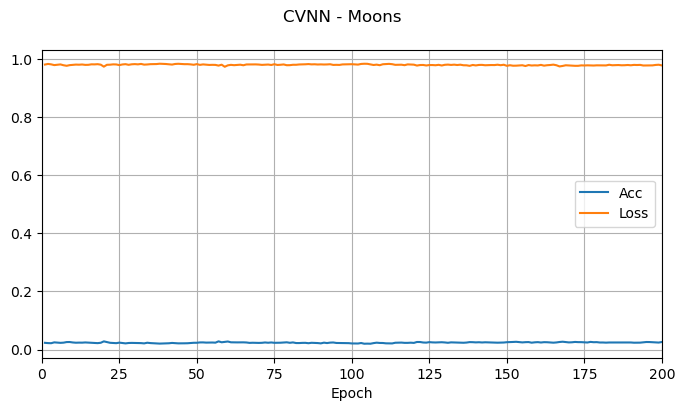

Train Acc.:  0.9850022432542141
Val Acc.:  0.9722269697487609
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1064
           1       0.98      0.95      0.97      1064
           2       1.00      0.99      0.99      1064
           3       1.00      0.99      0.99      1063
           4       0.98      0.96      0.97      1064
           5       0.97      0.98      0.97      1064
           6       0.98      0.96      0.97      1063
           7       1.00      1.00      1.00      1064
           8       1.00      1.00      1.00      1064
           9       0.97      0.97      0.97      1064
          10       0.99      0.98      0.99      1064

   micro avg       0.99      0.98      0.98     11702
   macro avg       0.99      0.98      0.98     11702
weighted avg       0.99      0.98      0.98     11702
 samples avg       0.97      0.98      0.98     11702



/tmp/ipykernel_210316/3139655883.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(


acc,█▆▅▆▅▆█▇▆▇▆▅▄▆▅▆▅▇▆▆▆▅█▆▄▅▄▁▄▃▃▂▄▁▃▂▃▃▂▃
loss,▃▄▄▄▄▃▃▂▃▂▅▄▅▄▅▅▃▃▃▃▁▄▁▄▇▆▅▆▅▅▆▄▅█▆▆▅▅▆▇
acc,0.97919
loss,0.02596


Epoch 9 loss is 0.02304907936105134
Epoch 19 loss is 0.02219663404389557
Epoch 29 loss is 0.022484629085466813
Epoch 39 loss is 0.021750896973484615
Epoch 49 loss is 0.024163170235373767
Epoch 59 loss is 0.03115489416672411
Epoch 69 loss is 0.027110886936363078
Epoch 79 loss is 0.02702489104077479
Epoch 89 loss is 0.024690306447012863
Epoch 99 loss is 0.02456612692250336
Epoch 109 loss is 0.02659471034629197
Epoch 119 loss is 0.02455203202863955
Epoch 129 loss is 0.025641652489555387
Epoch 139 loss is 0.043864441527690895
Epoch 149 loss is 0.02646372443915028
Epoch 159 loss is 0.028787667921727923
Epoch 169 loss is 0.032389624229182463
Epoch 179 loss is 0.029450554263280984
Epoch 189 loss is 0.028827977301186736
Epoch 199 loss is 0.02788845972826256


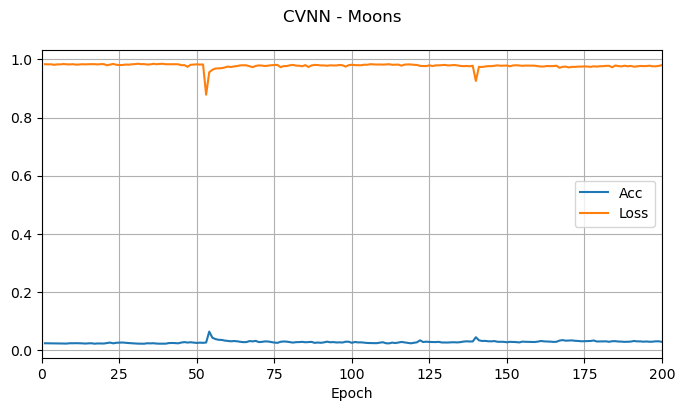

Train Acc.:  0.9851090648834576
Val Acc.:  0.9748760895573406
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1063
           1       0.98      0.97      0.97      1064
           2       1.00      0.99      0.99      1064
           3       0.99      0.99      0.99      1063
           4       0.97      0.97      0.97      1064
           5       0.98      0.97      0.98      1064
           6       0.97      0.97      0.97      1064
           7       1.00      0.99      1.00      1064
           8       1.00      1.00      1.00      1064
           9       0.98      0.97      0.98      1064
          10       0.99      0.98      0.99      1064

   micro avg       0.99      0.98      0.98     11702
   macro avg       0.99      0.98      0.98     11702
weighted avg       0.99      0.98      0.98     11702
 samples avg       0.98      0.98      0.98     11702



/tmp/ipykernel_210316/3139655883.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train, y_train, x_valid, y_valid = map(


acc,▇▇▇█▇▆▇█▇▆▇▁▄▃▅▅▅▆▅▄▆▇▇▇▅▆▆▄▅▅▅▅▅▄▄▄▃▅▅▆
loss,▂▁▂▂▃▃▁▂▂▃▂█▅▄▄▄▃▂▄▄▃▂▁▂▆▄▃▄▅▄▃▄▄▆▅▆▅▄▄▄
acc,0.98002
loss,0.02789


Epoch 9 loss is 0.02868753717197222
Epoch 19 loss is 0.024206067677403572
Epoch 29 loss is 0.026760341788020104
Epoch 39 loss is 0.027146450485628706
Epoch 49 loss is 0.02521556296025377
Epoch 59 loss is 0.026459431802319747
Epoch 69 loss is 0.025464020568984592
Epoch 79 loss is 0.025356624387098445
Epoch 89 loss is 0.025717462035970404
Epoch 99 loss is 0.02667336908638915
Epoch 109 loss is 0.027087383284956256
Epoch 119 loss is 0.029282985835724105
Epoch 129 loss is 0.028914905926814383
Epoch 139 loss is 0.029572675112530124
Epoch 149 loss is 0.028363622785860267
Epoch 159 loss is 0.03134395028021653
Epoch 169 loss is 0.02959949097499508
Epoch 179 loss is 0.031079704940657923
Epoch 189 loss is 0.0327633203448539
Epoch 199 loss is 0.03458949387064709


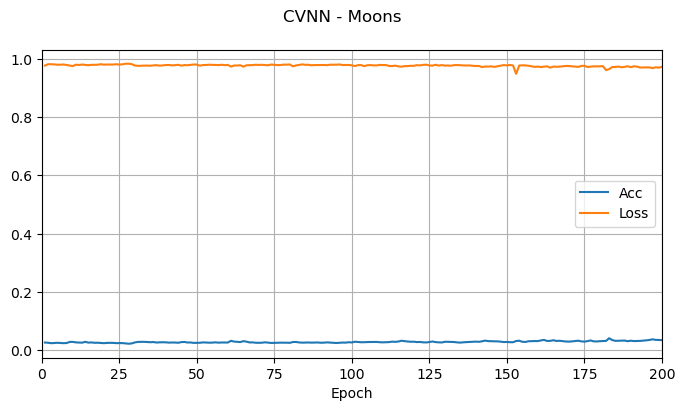

Train Acc.:  0.983805841006687
Val Acc.:  0.9724833361818492
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1064
           1       0.96      0.97      0.96      1064
           2       1.00      0.99      0.99      1064
           3       1.00      0.99      0.99      1064
           4       0.97      0.96      0.97      1064
           5       0.98      0.97      0.97      1064
           6       0.98      0.96      0.97      1063
           7       1.00      1.00      1.00      1064
           8       1.00      1.00      1.00      1063
           9       0.98      0.97      0.98      1064
          10       0.99      0.98      0.98      1064

   micro avg       0.99      0.98      0.98     11702
   macro avg       0.99      0.98      0.98     11702
weighted avg       0.99      0.98      0.98     11702
 samples avg       0.98      0.98      0.98     11702



In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
list_acc = []
list_loss = []
for train_index, test_index in sss.split(X, y):
    model_dict: dict = {}
    x_train, x_valid, y_train, y_valid = get_splitted_data_by_index(
        X, y, neuronCats, train_index, test_index
    )
    losses, scores = fit(
        model,
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        criterion=criterion,
        categories=categories,
        periodicity=periodicity,
    )

    model.load_state_dict(torch.load(PATH))

    plot_loss(
        "CVNN - Autass",
        losses,
        scores,
    )

    list_acc.append(scores)
    list_loss.append(losses)

    y_pred = model.predict(x_train)
    acc = accuracy(y_pred.squeeze(), y_train)
    print("Train Acc.: ", acc)

    y_pred = model.predict(x_valid)
    acc = accuracy(y_pred.squeeze(), y_valid)
    print("Val Acc.: ", acc)

    print(classification_report(y_valid, y_pred.detach().numpy(), zero_division=0))

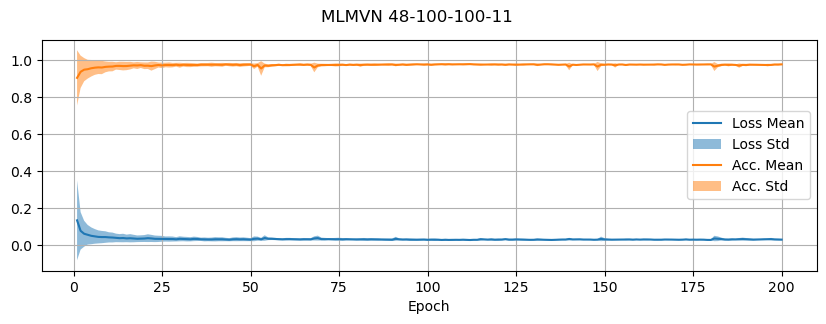

In [ ]:
title = "MLMVN 48-100-100-11"
image_name = "results/MLMVN_48-100-11.png"
plot_loss_acc_list(title, list_loss, list_acc, image_name)

## Plot Model Weights

In [ ]:
# for key in model_dict:
#     print(key)
#     list_weights = model_dict[key]["weights"]
#     list_bias = model_dict[key]["bias"]

#     weights = []
#     biases = []
#     for weight, bias in zip(list_weights, list_bias):
#         # test = list_weights[0][0].flatten() + list_weights[0][1].flatten()
#         weights.append(np.concatenate([weight.flatten()]))
#         biases.append(np.concatenate([bias.flatten()]))

#     weights_real = np.real(weights)
#     weights_imag = np.imag(weights)

#     weights_mag = np.abs(weights)
#     weights_angle = np.angle(weights)

#     bias_real = np.real(biases)
#     bias_imag = np.imag(biases)

#     bias_mag = np.abs(biases)
#     bias_angle = np.angle(biases)

#     plot_weights(str(key)+" weights", "Weights [Re]", "Weigths [Imag]", weights_real, weights_imag)
#     plot_weights(str(key)+" bias", "Bias [Re]", "Bias [Imag]", bias_real, bias_imag)
#     plot_weights(str(key)+" bias", "Bias [Re]", "Bias [Imag]", weights_mag, weights_angle)
#     plot_weights(str(key)+" bias", "Bias [Re]", "Bias [Imag]", bias_mag, bias_angle)